# Blackjack-v0

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

### Use Environment

In [2]:
env = gym.make("Blackjack-v0")
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

23:15:42 [INFO] action_space: Discrete(2)
23:15:42 [INFO] observation_space: Tuple(Discrete(32), Discrete(11), Discrete(2))
23:15:42 [INFO] np_random: RandomState(MT19937)
23:15:42 [INFO] natural: False
23:15:42 [INFO] dealer: [2, 10]
23:15:42 [INFO] player: [8, 7]
23:15:42 [INFO] spec: EnvSpec(Blackjack-v0)


### On-policy Monte Carlo

Monte Carlo prediction

In [3]:
def ob2state(observation):
    return observation[0], observation[1], int(observation[2])

def evaluate_action_monte_carlo(env, policy, episode_num=500000):
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play an episode
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # end of episode
        g = reward # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
    return q

In [4]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1 # stop when >=20
policy[:20, :, :, 1] = 1 # continue when <20

q = evaluate_action_monte_carlo(env, policy) # action value
v = (q * policy).sum(axis=-1) # state value

In [5]:
def play_policy(env, policy=None):
    observation, reward, done = env.reset(), 0., False
    episode_reward, elapsed_steps = 0., 0
    logging.debug('observation = %s', observation)
    while True:
        logging.debug('player = %s, dealer = %s', env.player, env.dealer)
        if policy is None:
            action = env.action_space.sample()
        else:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        logging.debug('action = %s', action)
        observation, reward, done, _ = env.step(action)
        logging.debug('observation = %s, reward = %s, done = %s',
                observation, reward, done)
        episode_reward += reward
        elapsed_steps += 1
        if done:
            break
    return episode_reward, elapsed_steps

episode_reward, elapsed_steps = play_policy(env)
logging.info("episode reward: %.2f", episode_reward)

23:16:44 [DEBUG] observation = (11, 10, False)
23:16:44 [DEBUG] player = [8, 3], dealer = [10, 9]
23:16:44 [DEBUG] action = 0
23:16:44 [DEBUG] observation = (11, 10, False), reward = -1.0, done = True
23:16:44 [INFO] episode reward: -1.00


In [6]:
def plot(data):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    titles = ['without ace', 'with ace']
    have_aces = [0, 1]
    extent = [12, 22, 1, 11]
    for title, have_ace, axis in zip(titles, have_aces, axes):
        dat = data[extent[0]:extent[1], extent[2]:extent[3], have_ace].T
        axis.imshow(dat, extent=extent, origin='lower')
        axis.set_xlabel('player sum')
        axis.set_ylabel('dealer showing')
        axis.set_title(title)

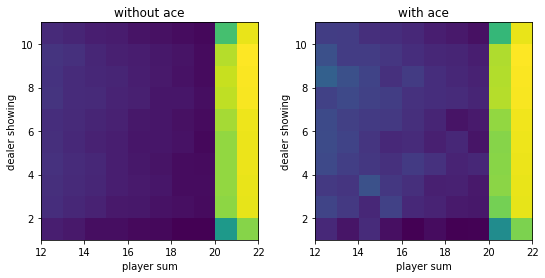

In [7]:
plot(v)

Test Policy

In [8]:
imp.reload(logging)
logging.basicConfig(level=logging.INFO, # reset display level to avoid too much output
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [9]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

23:16:45 [INFO] average episode reward = -0.32 ± 0.93


In [10]:
env.reset()

(13, 10, False)

In [11]:
policy[tuple(env.reset())]

array([], shape=(0, 2, 2), dtype=float64)

#### Monte Carlo update with exploring start

In [12]:
def monte_carlo_with_exploring_start(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 1] = 1.
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # choose initial state randomly
        state = (np.random.randint(12, 22),
                 np.random.randint(1, 11),
                 np.random.randint(2))
        action = np.random.randint(2)
        # play an episode
        env.reset()
        if state[2]: # has ace
            env.player = [1, state[0] - 11]
        else: # no ace
            if state[0] == 21:
                env.player = [10, 9, 2]
            else:
                env.player = [10, state[0] - 10]
        env.dealer[0] = state[1]
        state_actions = []
        while True:
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # end of episode
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        g = reward # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
    return policy, q

In [13]:
policy, q = monte_carlo_with_exploring_start(env)
v = q.max(axis=-1)

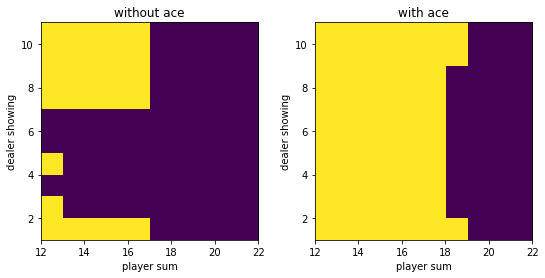

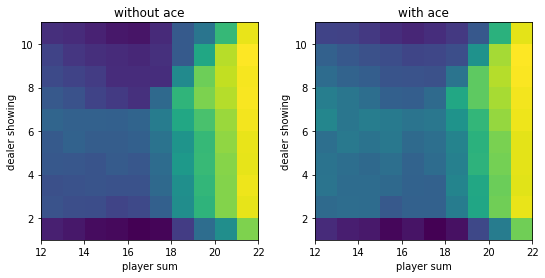

In [14]:
plot(policy.argmax(-1))
plot(v)

Monte Carlo update with soft poicy

In [15]:
def monte_carlo_with_soft(env, episode_num=500000, epsilon=0.1):
    policy = np.ones((22, 11, 2, 2)) * 0.5 # soft policy
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play an episode
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # end of episode
        g = reward # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            # soft update
            a = q[state].argmax()
            policy[state] = epsilon / 2.
            policy[state][a] += (1. - epsilon)
    return policy, q

In [16]:
policy, q = monte_carlo_with_soft(env)
v = q.max(axis=-1)

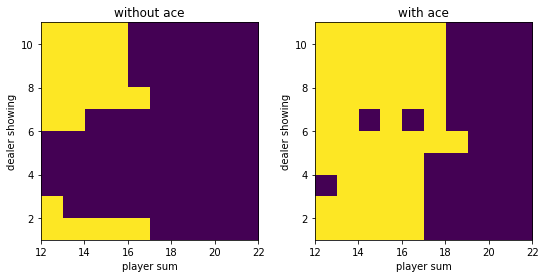

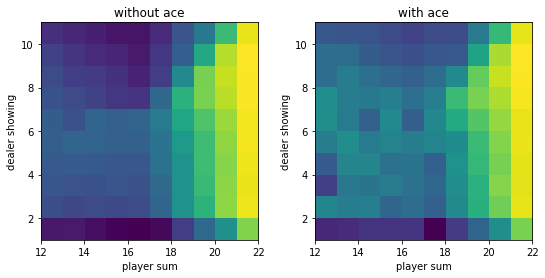

In [17]:
plot(policy.argmax(-1))
plot(v)

Test Policy

In [18]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

23:18:33 [INFO] average episode reward = -0.12 ± 0.96


### Off-Policy Monte Carlo Update

Monte Carlo evaluation with importance sampling

In [19]:
def evaluate_monte_carlo_importance_sample(env, policy, behavior_policy,
        episode_num=500000):
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play episode using behavior policy
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # finish the episode
        g = reward # return
        rho = 1. # importance sampling ratio
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            rho *= (policy[state][action] / behavior_policy[state][action])
            if rho == 0:
                break # early stop
    return q

In [20]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1 # stop when >=20
policy[:20, :, :, 1] = 1 # continue when <20
behavior_policy = np.ones_like(policy) * 0.5
q = evaluate_monte_carlo_importance_sample(env, policy, behavior_policy)
v = (q * policy).sum(axis=-1)

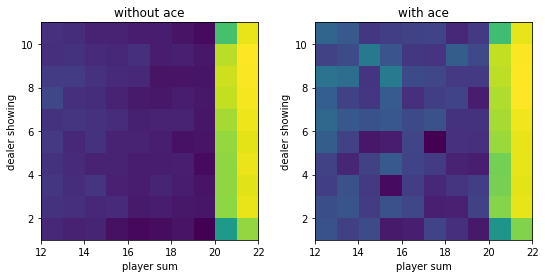

In [21]:
plot(v)

Monte Carlo update with importance sampling

In [22]:
def monte_carlo_importance_sample(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 0] = 1.
    behavior_policy = np.ones_like(policy) * 0.5 # soft policy
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play using behavior policy
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # finish the episode
        g = reward # return
        rho = 1. # importance sampling ratio
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            # improve the policy
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
            if a != action: # early stop
                break
            rho /= behavior_policy[state][action]
    return policy, q

In [23]:
policy, q = monte_carlo_importance_sample(env)
v = q.max(axis=-1)

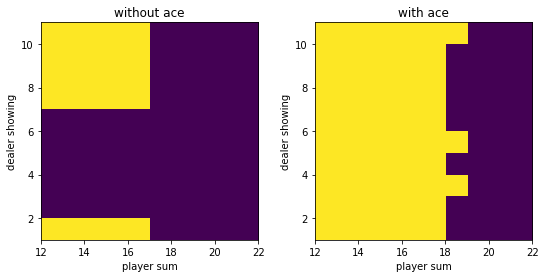

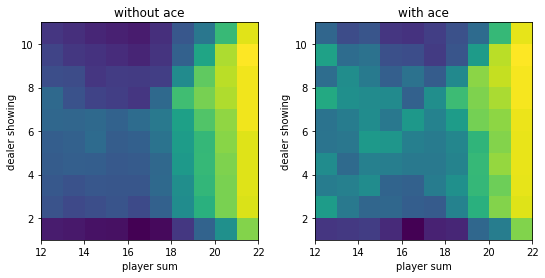

In [24]:
plot(policy.argmax(-1))
plot(v)

Test Policy

In [25]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

23:20:32 [INFO] average episode reward = 0.04 ± 0.95


In [26]:
env.close()